In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tkinter as tk
from PIL import Image, ImageDraw, ImageOps
import tensorflow_datasets as tfds
import tensorflow as tf

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/incomplete.LZZRLK_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/incomplete.LZZRLK_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/letters/3.1.0. Subsequent calls will reuse this data.


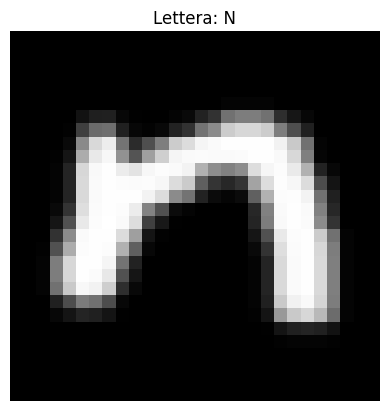

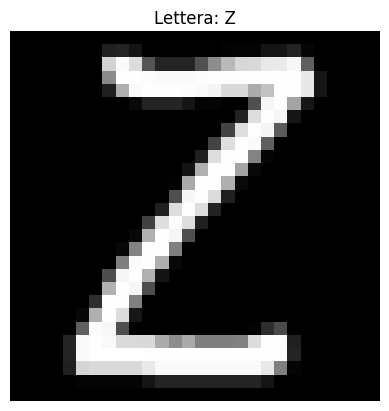

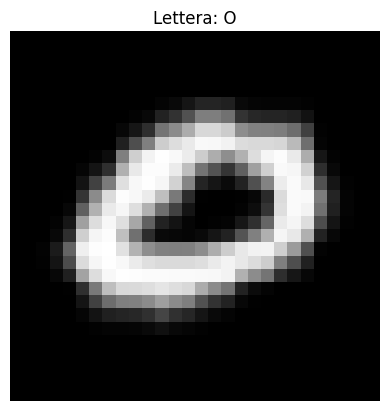

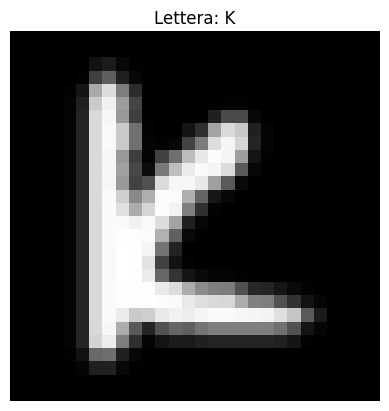

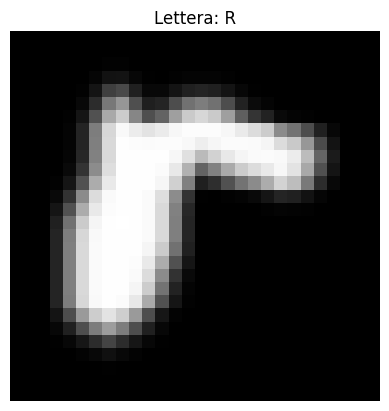

In [4]:
# Carica il dataset EMNIST Letters (train e test)
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

# Funzione di preprocessing: normalizza, ruota, specchia, e corregge labels (0-25)
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.rot90(image, k=-1)          # Ruota 90° in senso orario
    image = tf.image.flip_left_right(image)      # Specchia orizzontalmente
    label -= 1  # Labels da 0 a 25
    image = tf.expand_dims(image, -1)  # Aggiungi canale per Conv2D (shape: 28x28x1)
    return image, label

# Applica preprocessing, shuffle, batch
batch_size = 32
ds_train = ds_train.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Visualizza qualche immagine dal dataset preprocessato
for images, labels in ds_train.take(1):
    for i in range(5):
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f"Lettera: {chr(int(labels[i]) + 65)}")  # 0='A'
        plt.axis("off")
        plt.show()

In [5]:
# Definisci il modello
model = Sequential([
    Conv2D(32, (2, 2), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(26, activation='softmax')
])

# Compila il modello usando sparse_categorical_crossentropy perché le labels sono intere (non one-hot)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Addestra il modello usando i dataset tf.data.Dataset (NON numpy array)
history = model.fit(ds_train,
                    epochs=10,
                    validation_data=ds_test)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2775/2775 ━━━━━━━━━━━━━━━━━━━━ 93s 32ms/step - accuracy: 0.6199 - loss: 1.2627 - val_accuracy: 0.8699 - val_loss: 0.4126
Epoch 2/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - accuracy: 0.8370 - loss: 0.5081 - val_accuracy: 0.8956 - val_loss: 0.3209
Epoch 3/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 142s 30ms/step - accuracy: 0.8631 - loss: 0.4212 - val_accuracy: 0.9030 - val_loss: 0.2981
Epoch 4/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 142s 30ms/step - accuracy: 0.8755 - loss: 0.3789 - val_accuracy: 0.9086 - val_loss: 0.2764
Epoch 5/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 87s 31ms/step - accuracy: 0.8851 - loss: 0.3459 - val_accuracy: 0.9104 - val_loss: 0.2677
Epoch 6/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 84s 30ms/step - accuracy: 0.8881 - loss: 0.3319 - val_accuracy: 0.9114 - val_loss: 0.2617
Epoch 7/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 86s 31ms/step - accuracy: 0.8953 - loss: 0.3120 - val_accuracy: 0.9142 - val_loss: 0.2542
Epoch 8/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - accuracy: 0.8980 - loss: 0.

Definiamo la struttura del model,
iniziamo usando flatten, esso ci permette di ridurre l'immagine a un vettore di 784 valori binari.

Definiamo i layer, uno per far comprendere al modello la struttura delle immagini con 128 neuroni e un activation type relu, ed il layer finale da 10 neuroni, uno per cifra, con activation type softmax, ideale per la classificazione con probabilità.

Diamo le direttive al modello specificando optimizer, loss sarà categorical_crossenthropy siccome abbiamo usato softmax come attivazione in output.

Infine definiamo l'addestramento.
Il batch size (o "dimensione del batch") è un iperparametro che definisce quanti esempi del dataset vengono processati insieme prima che la rete neurale aggiorni i suoi pesi.

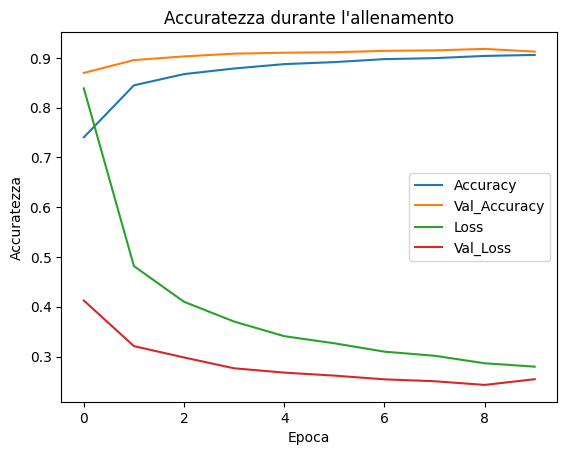

In [6]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.title('Accuratezza durante l\'allenamento')
plt.xlabel('Epoca')
plt.ylabel('Accuratezza')
plt.legend()
plt.show()

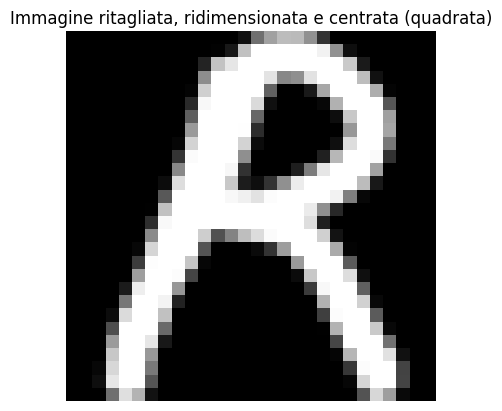

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


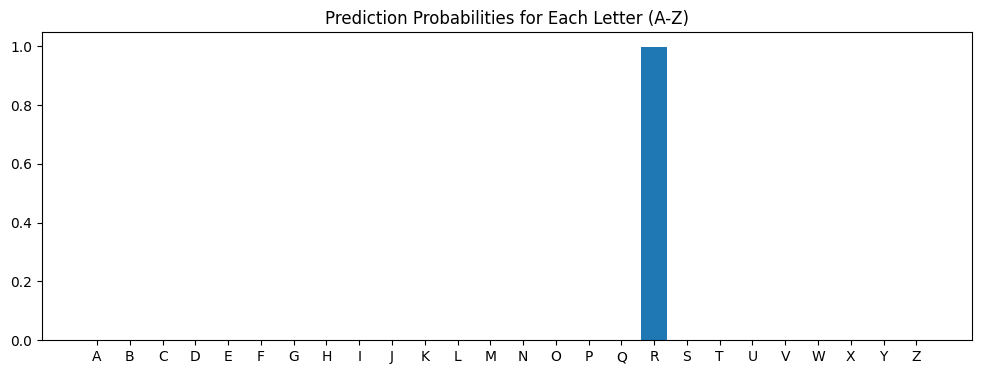

In [8]:
from IPython.display import display, HTML
from google.colab import output
import base64
import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

canvas_html = """
<canvas id="canvas" width="280" height="280" style="border:1px solid black;"></canvas>
<br>
<button onclick="predict()">Predict</button>
<button onclick="clearCanvas()">Clear</button>

<script>
let canvas = document.getElementById('canvas');
let ctx = canvas.getContext('2d');
let drawing = false;

canvas.addEventListener('mousedown', () => { drawing = true; });
canvas.addEventListener('mouseup', () => { drawing = false; ctx.beginPath(); });
canvas.addEventListener('mouseout', () => { drawing = false; ctx.beginPath(); });

canvas.addEventListener('mousemove', (event) => {
  if (!drawing) return;
  ctx.lineWidth = 20;
  ctx.lineCap = "round";
  ctx.strokeStyle = "white";
  ctx.lineTo(event.offsetX, event.offsetY);
  ctx.stroke();
  ctx.beginPath();
  ctx.moveTo(event.offsetX, event.offsetY);
});

ctx.fillStyle = "black";
ctx.fillRect(0, 0, canvas.width, canvas.height);

function clearCanvas() {
  ctx.fillStyle = "black";
  ctx.fillRect(0, 0, canvas.width, canvas.height);
}

function predict() {
  const dataURL = canvas.toDataURL();
  google.colab.kernel.invokeFunction('notebook.predict_digit', [dataURL], {});
}
</script>
"""

display(HTML(canvas_html))

def preprocess_image(img):
    img = img.convert('L')
    img_array = np.array(img)
    non_black_pixels = np.where(img_array > 0)
    if non_black_pixels[0].size > 0:
        y_min, x_min = np.min(non_black_pixels[0]), np.min(non_black_pixels[1])
        y_max, x_max = np.max(non_black_pixels[0]), np.max(non_black_pixels[1])
        max_dim = max(y_max - y_min, x_max - x_min)
        center_x = (x_min + x_max) // 2
        center_y = (y_min + y_max) // 2
        new_x_min = max(0, center_x - max_dim // 2 - 2)
        new_x_max = min(img_array.shape[1], center_x + max_dim // 2 + 2)
        new_y_min = max(0, center_y - max_dim // 2 - 2)
        new_y_max = min(img_array.shape[0], center_y + max_dim // 2 + 2)
        crop_width = new_x_max - new_x_min
        crop_height = new_y_max - new_y_min
        max_crop_dim = max(crop_width, crop_height)
        if crop_width < max_crop_dim:
            diff = max_crop_dim - crop_width
            new_x_min = max(0, new_x_min - diff // 2)
            new_x_max = min(img_array.shape[1], new_x_max + (diff - diff // 2))
        if crop_height < max_crop_dim:
            diff = max_crop_dim - crop_height
            new_y_min = max(0, new_y_min - diff // 2)
            new_y_max = min(img_array.shape[0], new_y_max + (diff - diff // 2))
        cropped_img_array = img_array[new_y_min:new_y_max, new_x_min:new_x_max]
        cropped_img = Image.fromarray(cropped_img_array)
    else:
        cropped_img = img
    size = max(cropped_img.size)
    new_img = Image.new('L', (size, size), color=0)
    new_img.paste(cropped_img, ((size - cropped_img.size[0]) // 2, (size - cropped_img.size[1]) // 2))
    new_img = new_img.resize((28, 28))
    plt.imshow(new_img, cmap='gray')
    plt.title('Immagine ritagliata, ridimensionata e centrata (quadrata)')
    plt.axis('off')
    plt.show()
    img_array = np.array(new_img).astype('float32') / 255.0
    img_array = np.expand_dims(img_array, -1)
    return np.expand_dims(img_array, 0)

def predict_digit(data):
    data = data.split(',')[1]
    binary = base64.b64decode(data)
    img = Image.open(io.BytesIO(binary))
    processed_img = preprocess_image(img)
    prediction = model.predict(processed_img)[0]
    pred_class = np.argmax(prediction)
    confidence = np.max(prediction)
    pred_letter = chr(pred_class + 65)
    display(HTML(f"<h3>Predicted: {pred_letter} (Confidence: {confidence:.2%})</h3>"))
    plt.figure(figsize=(12, 4))
    plt.bar(range(26), prediction)
    plt.xticks(range(26), [chr(i + 65) for i in range(26)])
    plt.title('Prediction Probabilities for Each Letter (A-Z)')
    plt.show()

output.register_callback('notebook.predict_digit', predict_digit)


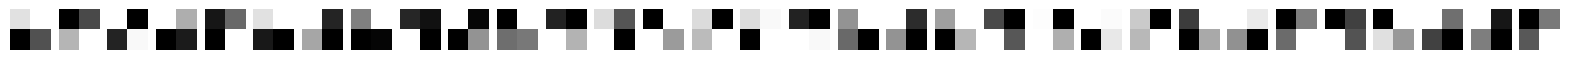

In [54]:
import matplotlib.pyplot as plt

# Prendi i pesi del primo layer conv2D
filters, biases = model.layers[0].get_weights()

# filters shape: (height, width, input_channels, num_filters)
num_filters = filters.shape[3]

fig, axes = plt.subplots(1, num_filters, figsize=(20,5))
for i in range(num_filters):
    f = filters[:, :, 0, i]  # prendi il filtro relativo al primo canale input
    axes[i].imshow(f, cmap='gray')
    axes[i].axis('off')
plt.show()

In [58]:
model.save_weights('modello_pesi.weights.h5')

from google.colab import files
files.download('modello_pesi.weights.h5')

model.save('modello_completo.h5')  # Salva struttura + pesi
files.download('modello_completo.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>